In [26]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import pickle
import yfinance as yf
from datetime import datetime

df = yf.download("VCB.VN", start=datetime(2000,1,1), end=datetime.today())
df = df.reset_index()

df.head(3)

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-06-30,22898.183594,22898.183594,22898.183594,22898.183594,22898.183594,770543
1,2009-07-01,24043.093750,24043.093750,22707.365234,23089.001953,23089.001953,16372619
2,2009-07-02,22707.365234,22898.183594,21944.093750,22134.912109,22134.912109,3971498


In [27]:
df.tail(3)

,Date,Open,High,Low,Close,Adj Close,Volume
3691,2024-04-24,91000.0,91100.0,90100.0,90600.0,90600.0,2190200
3692,2024-04-25,90600.0,92900.0,90500.0,91000.0,91000.0,1334700
3693,2024-04-26,91700.0,93300.0,91200.0,91200.0,91200.0,1763300


In [28]:
df.shape

(3694, 7)

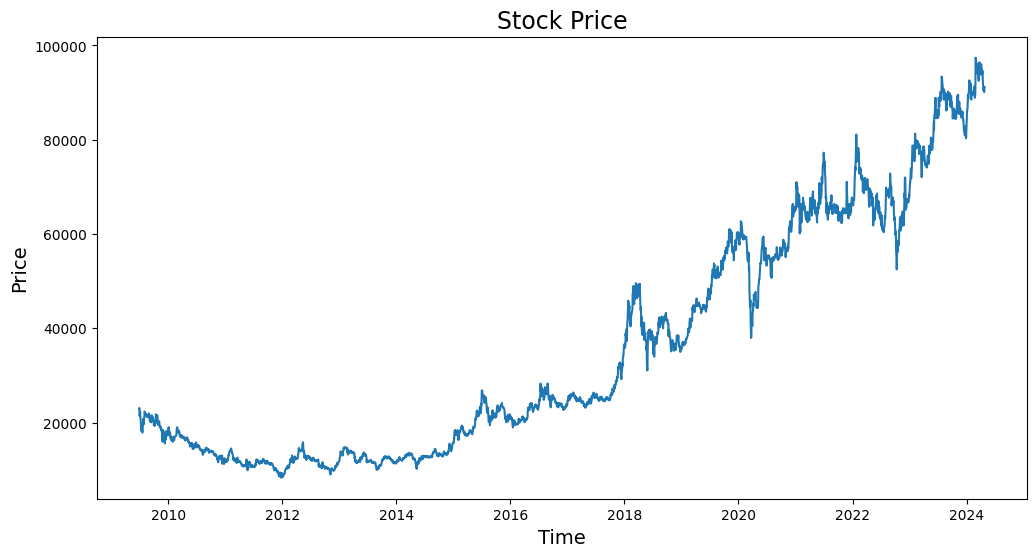

In [29]:
# Plot time series chart
plt.figure(figsize=(12,6))
plt.plot(df['Date'],df['Close'])
plt.title("Stock Price", fontsize=17)
plt.ylabel('Price', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.show()

# Data Preprocessing

Standardize the data

In [30]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
df['scaled_close'] = standard_scaler.fit_transform(df['Close'].to_numpy().reshape(-1,1))


Split the data into train, test set (90/10)

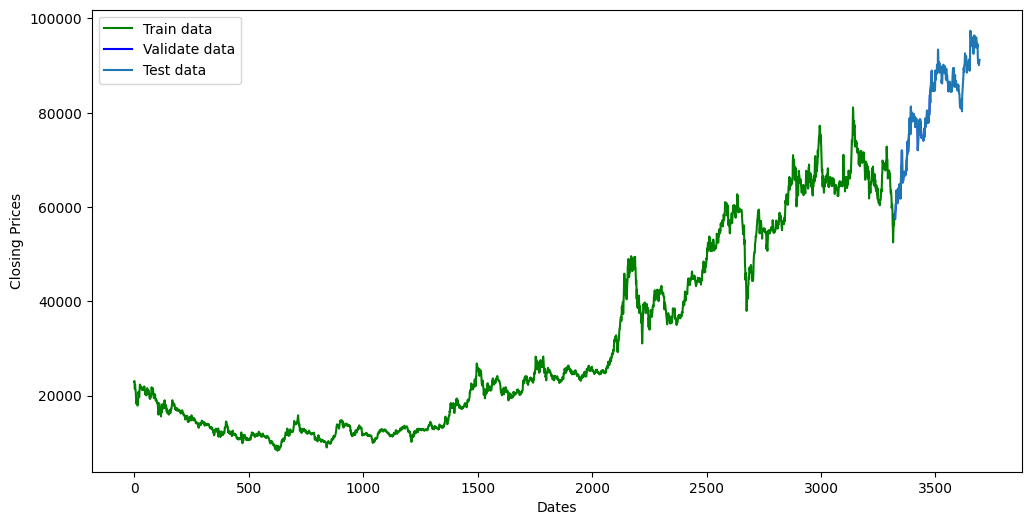

In [31]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, shuffle=False, test_size=0.1)

# plotting the data
plt.figure(figsize=(12,6))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data['Close'], 'green', label='Train data')
plt.plot(validate_data['Close'], 'blue', label='Validate data')
plt.plot(test_data['Close'], label='Test data')
plt.legend()


Transform the time-series data into a matrix <br>
Each row is the historical data from day i to day i + window_size (by default, window_size = 60)

In [32]:
def prepare_data(data, window_size=60):
    X = []
    y = []
    for i in range(window_size,data.shape[0]):
        X.append(data.iloc[i-window_size:i])
        y.append(data.iloc[i])

    X = np.array(X)
    y = np.array(y)

    return X,y

X_train, y_train = prepare_data(data=train_data['scaled_close'], window_size=60)
X_test, y_test = prepare_data(data=test_data['scaled_close'], window_size=60)

# Fitting model

## Support vector machine for regression

Hyperparameter tuning for SVM

In [33]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

parameter_grid = {'kernel':['rbf', 'poly'],
                  'degree':list(range(1,6)),
                  'shrinking':[True, False],
                  }

svm_model = SVR()
grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=parameter_grid, n_jobs=-1)

# svm_best_param = grid_search_no_cv(model=svm_model, param_grid=parameter_grid,
#                                           X_train=X_train, y_train=y_train,
#                                           X_val=X_val, y_val=y_val)

# svm_model.set_params(**svm_best_param)
# svm_model.fit(X_train, y_train)
grid_search_svm.fit(X_train, y_train)



GridSearchCV(estimator=SVR(), n_jobs=-1,
             param_grid={'degree': [1, 2, 3, 4, 5], 'kernel': ['rbf', 'poly'],
                         'shrinking': [True, False]})

Save model using pickle module

In [34]:
pickle.dump(svm_model, open("svm_model.txt",'wb'))

In [35]:
svm_y_pred = grid_search_svm.predict(X_test)
svm_y_pred = standard_scaler.inverse_transform(svm_y_pred.reshape(-1,1))

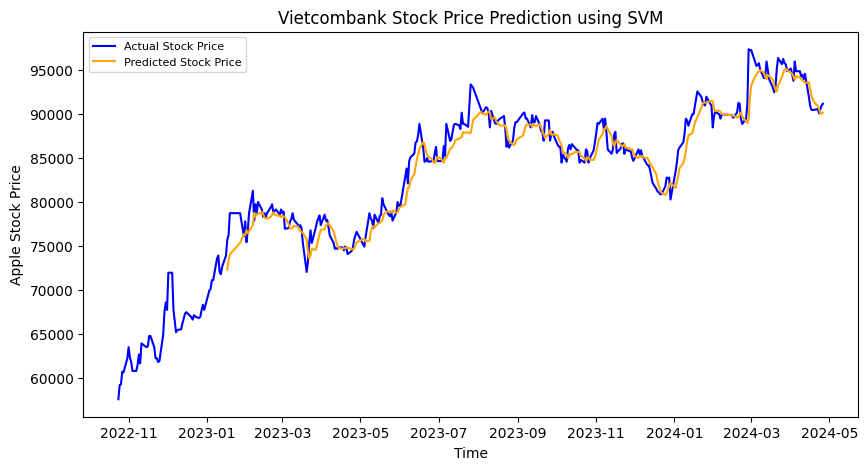

In [36]:
# plot all the series together
plt.figure(figsize=(10,5), dpi=100)
# plt.plot(train_data['Date'], train_data['Close'], color = 'red', label='Training data')
# plt.plot(validate_data['Date'], validate_data['Close'], color = 'green', label='Validation data')
plt.plot(test_data['Date'], test_data['Close'], color = 'blue', label='Actual Stock Price')
plt.plot(test_data[60:]['Date'], svm_y_pred, color = 'orange',label='Predicted Stock Price')

plt.title('Vietcombank Stock Price Prediction using SVM')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [37]:
from sklearn.metrics import mean_absolute_error,\
                            mean_squared_error,\
                            root_mean_squared_error,\
                            mean_absolute_percentage_error

y_true = test_data[60:]['Close'].values

# report performance
mse = mean_squared_error(y_true, svm_y_pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(y_true, svm_y_pred)
print('MAE: '+str(mae))
rmse = root_mean_squared_error(y_true, svm_y_pred)
print('RMSE: '+str(rmse))
mape = mean_absolute_percentage_error(y_true, svm_y_pred)*100
print('MAPE: '+str(mape)+'%')

MSE: 2414716.500532913
MAE: 1141.2681887575163
RMSE: 1553.9358096565356
MAPE: 1.3340673983333793%


## Ridge regression

In [38]:
from sklearn.linear_model import Ridge

params_grid = {'alpha':list(range(1,5))}

ridge_model = Ridge()
grid_search_ridge = GridSearchCV(estimator=ridge_model, param_grid=params_grid)
grid_search_ridge.fit(X_train, y_train)



GridSearchCV(estimator=Ridge(), param_grid={'alpha': [1, 2, 3, 4]})

In [39]:
pickle.dump(ridge_model, open('ridge.txt','wb'))

In [40]:
ridge_y_pred = grid_search_ridge.predict(X_test)
ridge_y_pred = standard_scaler.inverse_transform(ridge_y_pred.reshape(-1,1))

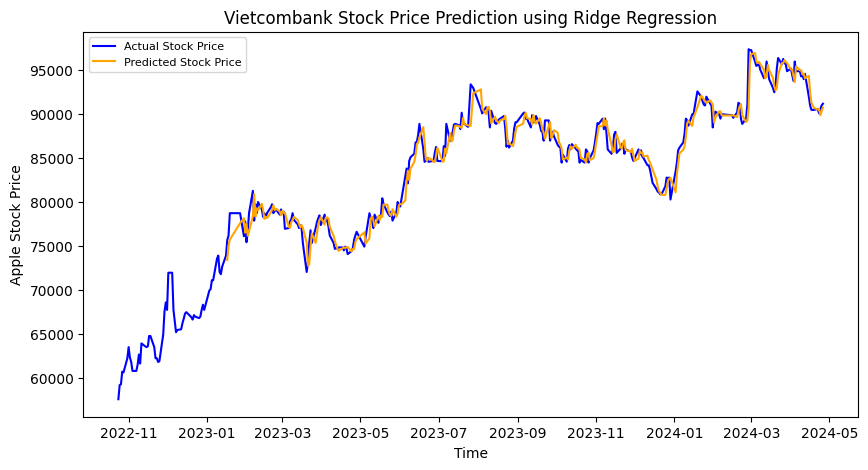

In [41]:
# plot all the series together
plt.figure(figsize=(10,5), dpi=100)
# plt.plot(train_data['Date'], train_data['Close'], color = 'red', label='Training data')
# plt.plot(validate_data['Date'], validate_data['Close'], color = 'green', label='Validation data')
plt.plot(test_data['Date'], test_data['Close'], color = 'blue', label='Actual Stock Price')
plt.plot(test_data[60:]['Date'], ridge_y_pred, color = 'orange',label='Predicted Stock Price')

plt.title('Vietcombank Stock Price Prediction using Ridge Regression')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [42]:
y_true = test_data[60:]['Close'].values

# report performance
mse = mean_squared_error(y_true, ridge_y_pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(y_true, ridge_y_pred)
print('MAE: '+str(mae))
rmse = root_mean_squared_error(y_true, ridge_y_pred)
print('RMSE: '+str(rmse))
mape = mean_absolute_percentage_error(y_true, ridge_y_pred)*100
print('MAPE: '+str(mape)+'%')

MSE: 1408221.6350164588
MAE: 878.8245478885601
RMSE: 1186.6851456963884
MAPE: 1.034853745079285%


## LSTM

In [43]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
x_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [45]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# define model architecture

# Initialize model
model = Sequential()

# LSTM layer 1
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.25))

# LSTM layer 2
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

# LSTM layer 3
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

# LSTM layer 4
model.add(LSTM(units = 50))
model.add(Dropout(0.25))

# final layer
model.add(Dense(units = 1))
model.summary()

/home/dangnguyen/b2/ml1/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 10, batch_size = 32)


Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - loss: 0.1221
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - loss: 0.0179
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 0.0159
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.0155
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 0.0133
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0146
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - loss: 0.0131
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 0.0125
Epoch 9/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 0.0122
Epoch 10/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - loss: 0.0110


In [47]:
model.save('lstm_model.keras')

In [48]:
# predict on test data
lstm_y_pred = model.predict(X_test)
lstm_y_pred = standard_scaler.inverse_transform(lstm_y_pred)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step


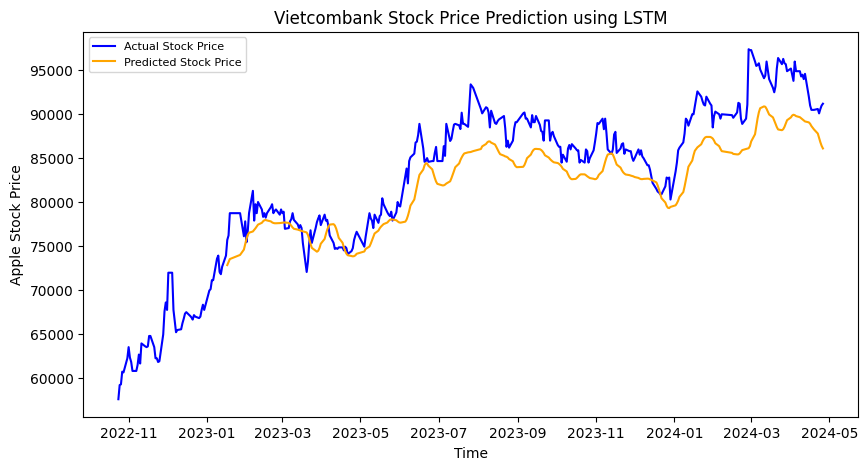

In [49]:
# plot all the series together
plt.figure(figsize=(10,5), dpi=100)
# plt.plot(train_data['Date'], train_data['Close'], color = 'red', label='Training data')
plt.plot(test_data['Date'], test_data['Close'], color = 'blue', label='Actual Stock Price')
plt.plot(test_data[60:]['Date'], lstm_y_pred, color = 'orange',label='Predicted Stock Price')

plt.title('Vietcombank Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [50]:
y_true = test_data[60:]['Close'].values

# report performance
mse = mean_squared_error(y_true, lstm_y_pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(y_true, lstm_y_pred)
print('MAE: '+str(mae))
rmse = root_mean_squared_error(y_true, lstm_y_pred)
print('RMSE: '+str(rmse))
mape = mean_absolute_percentage_error(y_true, lstm_y_pred) * 100

print('MAPE: '+str(mape) + "%")

MSE: 13867620.632564815
MAE: 3144.329133064516
RMSE: 3723.9254332712967
MAPE: 3.5864062041568285%
